### Predicting Football Results Using Python and the Dixon and Coles Model

http://www.pena.lt/y/2021/06/24/predicting-football-results-using-python-and-dixon-and-coles/

In [2]:
import pandas as pd

df = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/E0.csv")
df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]].head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,11/08/2017,Arsenal,Leicester,4,3
1,12/08/2017,Brighton,Man City,0,2
2,12/08/2017,Chelsea,Burnley,2,3
3,12/08/2017,Crystal Palace,Huddersfield,0,3
4,12/08/2017,Everton,Stoke,1,0


In [3]:
def rho_correction(goals_home, goals_away, home_exp, away_exp, rho):
    if goals_home == 0 and goals_away == 0:
        return 1 - (home_exp * away_exp * rho)
    elif goals_home == 0 and goals_away == 1:
        return 1 + (home_exp * rho)
    elif goals_home == 1 and goals_away == 0:
        return 1 + (away_exp * rho)
    elif goals_home == 1 and goals_away == 1:
        return 1 - rho
    else:
        return 1.0

In [4]:
def log_likelihood(
    goals_home_observed,
    goals_away_observed,
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
    rho,
):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)

    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)
    adj_llk = rho_correction(
        goals_home_observed,
        goals_away_observed,
        goal_expectation_home,
        goal_expectation_away,
        rho,
    )

    if goal_expectation_home < 0 or goal_expectation_away < 0 or adj_llk < 0:
        return 10000

    log_llk = np.log(home_llk) + np.log(away_llk) + np.log(adj_llk)

    return -log_llk

In [5]:
from pprint import pprint
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson


def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)

    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
            [-0.1], # rho
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],
        )
    )

    print("Log Likelihood: ", res["fun"])

    return model_params

In [6]:
model_params = fit_poisson_model()
pprint(model_params)

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_1447/1988307049.py:27: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk) + np.log(adj_llk)


Log Likelihood:  1050.8007454153371
{'attack_Arsenal': 1.4475876074687708,
 'attack_Bournemouth': 0.9563970345219176,
 'attack_Brighton': 0.6846820927599968,
 'attack_Burnley': 0.6983221231088574,
 'attack_Chelsea': 1.2572278425450487,
 'attack_Crystal Palace': 0.9493677930218464,
 'attack_Everton': 0.9377283607780433,
 'attack_Huddersfield': 0.4893228224732791,
 'attack_Leicester': 1.1898901107609958,
 'attack_Liverpool': 1.5643604160766347,
 'attack_Man City': 1.7860035559294256,
 'attack_Man United': 1.330940764349619,
 'attack_Newcastle': 0.7670394726456302,
 'attack_Southampton': 0.7651838505499925,
 'attack_Stoke': 0.7195713835591065,
 'attack_Swansea': 0.466452620166056,
 'attack_Tottenham': 1.4273418653894865,
 'attack_Watford': 0.9338795422526426,
 'attack_West Brom': 0.5837225563486147,
 'attack_West Ham': 1.0449781852940332,
 'defence_Arsenal': -0.9057986578232111,
 'defence_Bournemouth': -0.7584651451948953,
 'defence_Brighton': -0.8945986415373341,
 'defence_Burnley': -1.2

In [7]:
home_team = "Arsenal"
away_team = "Chelsea"

home_attack = model_params["attack_" + home_team]
home_defence = model_params["defence_" + home_team]
away_attack = model_params["attack_" + away_team]
away_defence = model_params["defence_" + away_team]
home_advantage = model_params["home_adv"]
rho = model_params["rho"]

home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
away_goal_expectation = np.exp(away_attack + home_defence)

home_probs = poisson.pmf([0, 1], home_goal_expectation)
away_probs = poisson.pmf([0, 1], away_goal_expectation)

probability_matrix_before = np.outer(home_probs, away_probs)

probability_matrix_after = probability_matrix_before.copy()
probability_matrix_after[0, 0] *= 1 - home_goal_expectation * away_goal_expectation * rho
probability_matrix_after[0, 1] *= 1 + home_goal_expectation * rho
probability_matrix_after[1, 0] *= 1 + away_goal_expectation * rho
probability_matrix_after[1, 1] *= 1 - rho

print(probability_matrix_after - probability_matrix_before)

[[ 0.01378011 -0.01378011]
 [-0.01378011  0.01378011]]


In [8]:
def dc_decay(xi, t):
    return np.exp(-xi * t)

Text(0, 0.5, 'Weight')

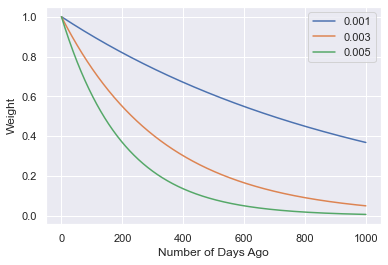

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

t = np.array(range(1000))
xis = [0.001, 0.003, 0.005]

for xi in xis:
    plt.plot(t, dc_decay(xi, t), label=str(xi))

plt.legend()
plt.xlabel("Number of Days Ago")
plt.ylabel("Weight")

In [10]:
import penaltyblog as pb
import pandas as pd

df = pd.concat([
  pb.footballdata.fetch_data("england", 2016, 0),
  pb.footballdata.fetch_data("england", 2017, 0),
  pb.footballdata.fetch_data("england", 2018, 0),
  pb.footballdata.fetch_data("england", 2019, 0),
  pb.footballdata.fetch_data("england", 2020, 0),   
])

AttributeError: module 'penaltyblog' has no attribute 'footballdata'

In [11]:
def log_likelihood(
    goals_home_observed,
    goals_away_observed,
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
    rho,
    weight
):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)

    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)
    adj_llk = rho_correction(
        goals_home_observed,
        goals_away_observed,
        goal_expectation_home,
        goal_expectation_away,
        rho,
    )

    if goal_expectation_home < 0 or goal_expectation_away < 0 or adj_llk < 0:
        return 10000

    log_llk = weight * (np.log(home_llk) + np.log(away_llk) + np.log(adj_llk))

    return -log_llk

In [12]:
def fit_poisson_model(df, xi=0.0001):
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)

    df["days_since"] = (df["Date"].max() - df["Date"]).dt.days
    df["weight"] = dc_decay(xi, df["days_since"])

    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
            [-0.1],  # rho
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho,
                row["weight"],
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],
        )
    )

    return model_params

In [13]:
def predict(params, home_team, away_team):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]
    rho = params["rho"]

    home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)

    home_probs = poisson.pmf(range(10), home_goal_expectation)
    away_probs = poisson.pmf(range(10), away_goal_expectation)

    m = np.outer(home_probs, away_probs)

    m[0, 0] *= 1 - home_goal_expectation * away_goal_expectation * rho
    m[0, 1] *= 1 + home_goal_expectation * rho
    m[1, 0] *= 1 + away_goal_expectation * rho
    m[1, 1] *= 1 - rho    

    home = np.sum(np.tril(m, -1))
    draw = np.sum(np.diag(m))
    away = np.sum(np.triu(m, 1))

    return home, draw, away

In [14]:
xis = [0, 0.00005, 0.0001, 0.001, 0.0025,]
rps = list()
for xi in xis:
    train = df.iloc[-380:]
    test = df.iloc[-380:]

    train["days_since"] = (train["Date"].max() - train["Date"]).dt.days
    train["weight"] = dc_decay(xi, train["days_since"])

    params = fit_poisson_model(train, xi)
    rps.append(calculate_rps(params, test))

plt.plot(xis, rps)
plt.ticklabel_format(useOffset=False)
plt.xlabel("xi")
plt.ylabel("RPS") 

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
import penaltyblog as pb
import pandas as pd
import numpy as np


def calculate_mean_rps(dc, df):
    rps = list()
    for idx, row in df.iterrows():
        if row["FTR"] == "H":
            outcome = 0
        elif row["FTR"] == "D":
            outcome = 1
        elif row["FTR"] == "A":
            outcome = 2

        predictions = dc.predict(row["HomeTeam"], row["AwayTeam"]).home_draw_away

        rps.append(pb.metrics.rps(predictions, outcome))

    return np.mean(rps)

df = pd.concat([
  pb.footballdata.fetch_data("england", 2016, 0),
  pb.footballdata.fetch_data("england", 2017, 0),
  pb.footballdata.fetch_data("england", 2018, 0),
  pb.footballdata.fetch_data("england", 2019, 0),
  pb.footballdata.fetch_data("england", 2020, 0),   
]).reset_index()

rps = list()
for xi in [0, 0.0001, 0.001, 0.02,]:
    train = df.iloc[:-300]
    test = df.iloc[-300:]

    train["weight"] = pb.poisson.dixon_coles_weights(train["Date"], xi)

    dc = pb.poisson.DixonColesGoalModel(
        train["FTHG"],
        train["FTAG"],
        train["HomeTeam"],
        train["AwayTeam"],
        train["weight"],
    )

    dc.fit()
    rps.append(calculate_mean_rps(dc, test))

print(rps)